# ALE plot interaction with pyALE

[Machine Learning Interpretability course](https://www.trainindata.com/p/machine-learning-interpretability)

In this notebook, we will create 2-feature ALE plots with pandas.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

from PyALE import ale

## Load data

In [2]:
# we'll just use the numerical variables to speed up the demo

variables = ['MSSubClass', 'LotArea', 'OverallQual', 'OverallCond',
             'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1',
             'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',  '1stFlrSF',
             '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
             'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
             'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars',
             'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch',
             '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal',
             'MoSold', 'YrSold', 'SalePrice']

# load dataset

data = pd.read_csv('../houseprice.csv', usecols=variables)

In [3]:
# separate train and test sets

X_train, X_test, y_train, y_test = train_test_split(
    data.drop(labels=['SalePrice'], axis=1),
    data['SalePrice'],
    test_size=0.3,
    random_state=0)

X_train.shape, X_test.shape

((1022, 33), (438, 33))

## Random Forest

In [4]:
# train model

rf = RandomForestRegressor(
    n_estimators=30,
    max_depth=3,
    random_state=3,
).fit(X_train, y_train)

In [5]:
# R2 in train set

rf.score(X_train, y_train)

0.8111905087278761

In [6]:
# R2 in test set

rf.score(X_test, y_test)

0.7848537001494764

The model explains > 75% of the variability in the target.

## Feature importance

Let's determine the feature importance derived from the model.

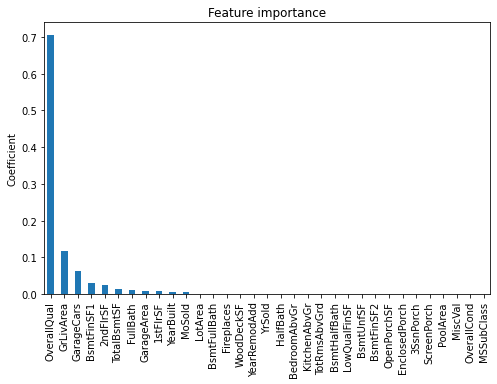

In [7]:
# put coefficients in a series

s = pd.Series(
    rf.feature_importances_,
    index=rf.feature_names_in_,
)

# plot coefficients
s.sort_values(ascending=False).plot.bar(figsize=(8, 5))
plt.title("Feature importance")
plt.ylabel("Coefficient")
plt.show()

## 1-D ALE plot

In [8]:
# This is the function from the first notebook
# to create 1-D ale plots

def plot_ale(model, X, feature, bins):
    
    feat_cut, bins = pd.cut(
        X[feature], 
        bins = bins,
        include_lowest=True,
        retbins=True,
    )
    
    bin_number = feat_cut.cat.codes
    
    # make a copy
    X1 = X.copy()
    X2 = X.copy()

    # replace with the lowest value in one df
    # and the highest value in the next:

    X1[feature] = [bins[i] for i in bin_number]
    X2[feature] = [bins[i + 1] for i in bin_number]
    
    # obtain predictions
    y_1 = model.predict(X1).ravel()
    y_2 = model.predict(X2).ravel()
    
    delta_df = pd.DataFrame({
        "bin": bins[bin_number + 1],
        "delta": y_2 - y_1,
    })
    
    res_df = delta_df.groupby(["bin"])["delta"].agg([("effect", "mean"), "size"])

    res_df["ale"] = res_df["effect"].cumsum()

    res_df.loc[min(bins), :] = 0
    
    mean_mv_avg = (
        (res_df["effect"] + res_df["effect"].shift(1, fill_value=0)) / \
        2 * res_df["size"]
    ).sum() / res_df["size"].sum()
    
    res_df = res_df.sort_index().assign(ale_centered=res_df["ale"] - mean_mv_avg)

    res_df.reset_index(inplace=True)
    
    # plot
    fig, ax = plt.subplots()
    fig.set_size_inches(8, 5)
    ax2 = ax.twinx()

    res_df["size"].plot.bar(ax=ax)
    res_df["ale_centered"].plot(ax=ax2, color="r")

    plt.title(f"ALE plot - {feature}")
    ax.set_ylabel("Number of observations")
    ax2.set_ylabel("Effect on prediction")
    plt.xticks(res_df.index, np.round(res_df["bin"],2))
    plt.show()

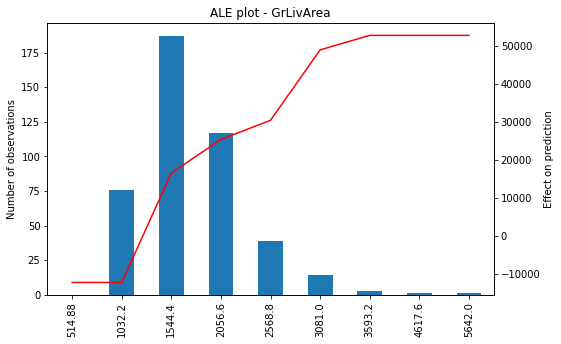

In [9]:
plot_ale(rf, X_test, "GrLivArea", 10)

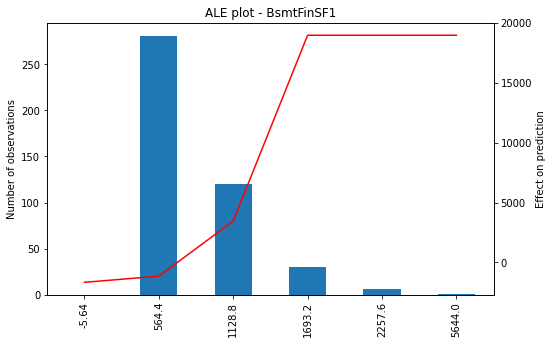

In [10]:
plot_ale(rf, X_test, "BsmtFinSF1", 10)

## 2-D ALE plots

Code adapted from [PyALE](https://github.com/DanaJomar/PyALE/blob/master/PyALE/_src/ALE_2D.py)

In [11]:
# we re-index to avoid problems when replacing values

X_test.reset_index(inplace=True, drop=True)

X_test.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,32668,6,3,1957,1975,1219,0,816,2035,...,484,0,0,200,0,0,0,0,3,2007
1,50,9490,6,7,1941,1950,403,165,238,806,...,240,0,0,32,0,0,0,0,8,2006
2,50,7015,5,4,1950,1950,185,0,524,709,...,352,0,0,248,0,0,0,0,7,2009
3,60,10005,7,5,1977,1977,392,0,768,1160,...,505,288,117,0,0,0,0,0,3,2008
4,160,1680,6,5,1971,1971,0,0,525,525,...,264,0,0,0,0,0,0,0,3,2010


In [12]:
features = ["GrLivArea", "BsmtFinSF1"]

In [13]:
# sort variable into quantiles
feat_cut_0, bins_0 = pd.qcut(X_test["GrLivArea"], q=10, retbins=True)

# catpure the number of the bin in which 
# observation was allocated
bin_codes_0 = feat_cut_0.cat.codes

# number of unique bin
bin_codes_unique_0 = np.unique(bin_codes_0)

In [14]:
# sort variable into quantiles
feat_cut_1, bins_1 = pd.qcut(X_test["BsmtFinSF1"], q=10, retbins=True, duplicates="drop",)

# catpure the number of the bin in which 
# observation was allocated
bin_codes_1 = feat_cut_1.cat.codes

# number of unique bin
bin_codes_unique_1 = np.unique(bin_codes_1)

In [15]:
X11 = X_test.copy()
X12 = X_test.copy()
X21 = X_test.copy()
X22 = X_test.copy()

In [16]:
# Create dataframes with combinations of the
# 4 edges of each cell

X11[features] = pd.DataFrame(
    {
        features[0]: [bins_0[i] for i in bin_codes_0],
        features[1]: [bins_1[i] for i in bin_codes_1],
    }
)

X12[features] = pd.DataFrame(
    {
        features[0]: [bins_0[i] for i in bin_codes_0],
        features[1]: [bins_1[i + 1] for i in bin_codes_1],
    }
)

X21[features] = pd.DataFrame(
    {
        features[0]: [bins_0[i + 1] for i in bin_codes_0],
        features[1]: [bins_1[i] for i in bin_codes_1],
    }
)

X22[features] = pd.DataFrame(
    {
        features[0]: [bins_0[i + 1] for i in bin_codes_0],
        features[1]: [bins_1[i + 1] for i in bin_codes_1],
    }
)

In [17]:
# Make predictions

y_11 = rf.predict(X11).ravel()
y_12 = rf.predict(X12).ravel()
y_21 = rf.predict(X21).ravel()
y_22 = rf.predict(X22).ravel()

In [18]:
# calculate the local effects

delta_df = pd.DataFrame(
    {
        features[0]: bin_codes_0 + 1,
        features[1]: bin_codes_1 + 1,
        "Delta": (y_22 - y_21) - (y_12 - y_11),
    }
)

delta_df

,GrLivArea,BsmtFinSF1,Delta
0,10,7,0.000000
1,7,3,0.000000
2,4,1,0.000000
3,9,3,0.000000
4,3,1,0.000000
...,...,...,...
433,5,2,0.000000
434,8,1,0.000000
435,9,7,0.000000
436,7,6,0.000000


In [19]:
index_combinations = pd.MultiIndex.from_product(
    [bin_codes_unique_0 + 1, bin_codes_unique_1 + 1], names=features
)

index_combinations

MultiIndex([( 1, 1),
            ( 1, 2),
            ( 1, 3),
            ( 1, 4),
            ( 1, 5),
            ( 1, 6),
            ( 1, 7),
            ( 2, 1),
            ( 2, 2),
            ( 2, 3),
            ( 2, 4),
            ( 2, 5),
            ( 2, 6),
            ( 2, 7),
            ( 3, 1),
            ( 3, 2),
            ( 3, 3),
            ( 3, 4),
            ( 3, 5),
            ( 3, 6),
            ( 3, 7),
            ( 4, 1),
            ( 4, 2),
            ( 4, 3),
            ( 4, 4),
            ( 4, 5),
            ( 4, 6),
            ( 4, 7),
            ( 5, 1),
            ( 5, 2),
            ( 5, 3),
            ( 5, 4),
            ( 5, 5),
            ( 5, 6),
            ( 5, 7),
            ( 6, 1),
            ( 6, 2),
            ( 6, 3),
            ( 6, 4),
            ( 6, 5),
            ( 6, 6),
            ( 6, 7),
            ( 7, 1),
            ( 7, 2),
            ( 7, 3),
            ( 7, 4),
            ( 7, 5),
            (

In [20]:
# Mean local effect per cell

delta_df = delta_df.groupby([features[0], features[1]]).Delta.agg(["size", "mean"])

delta_df

size        mean
GrLivArea BsmtFinSF1                  
1         1             18    0.000000
          2             10    0.000000
          3              5    0.000000
          4              5    0.000000
          5              5    0.000000
...                    ...         ...
10        3              2    0.000000
          4              1    0.000000
          5              2    0.000000
          6              8    0.000000
          7              9  920.143074

[66 rows x 2 columns]

In [21]:
# For the normalization

sizes_df = delta_df["size"].reindex(index_combinations, fill_value=0)
sizes_0 = sizes_df.groupby(level=0).sum().reindex(range(len(bins_0)), fill_value=0)
sizes_1 = sizes_df.groupby(level=1).sum().reindex(range(len(bins_0)), fill_value=0)

In [22]:
eff_df = delta_df["mean"].reindex(index_combinations, fill_value=np.nan)

eff_df

GrLivArea  BsmtFinSF1
1          1               0.000000
           2               0.000000
           3               0.000000
           4               0.000000
           5               0.000000
                            ...    
10         3               0.000000
           4               0.000000
           5               0.000000
           6               0.000000
           7             920.143074
Name: mean, Length: 70, dtype: float64

In [23]:
# cumulative sum of the difference

eff_df = eff_df.groupby(level=0).cumsum().groupby(level=1).cumsum()

eff_df

GrLivArea  BsmtFinSF1
1          1                0.000000
           2                0.000000
           3                0.000000
           4                0.000000
           5                0.000000
                            ...     
10         3             2006.040378
           4             2886.007161
           5             2886.007161
           6             2886.007161
           7             3806.150234
Name: mean, Length: 70, dtype: float64

In [24]:
# ============== centering with the moving average ================= #

# subtract the cumulative sum of the mean of 1D moving average (for each axis)
eff_df_0 = eff_df - eff_df.groupby(level=1).shift(periods=1, fill_value=0)
fJ0 = (
    (
        sizes_df
        * (
            eff_df_0.groupby(level=0).shift(periods=1, fill_value=0)
            + eff_df_0
        )
        / 2
    )
    .groupby(level=0)
    .sum()
    .div(sizes_0)
    .fillna(0)
    .cumsum()
)

eff_df_1 = eff_df - eff_df.groupby(level=0).shift(periods=1, fill_value=0)
fJ1 = (
    (
        sizes_df
        * (eff_df_1.groupby(level=1).shift(periods=1, fill_value=0) + eff_df_1)
        / 2
    )
    .groupby(level=1)
    .sum()
    .div(sizes_1)
    .fillna(0)
    .cumsum()
)

all_combinations = pd.MultiIndex.from_product(
    [[x for x in range(len(bins_0))], [x for x in range(len(bins_1))]],
    names=features,
)
eff_df = eff_df.reindex(all_combinations, fill_value=0)
eff_df = eff_df.subtract(fJ0, level=0).subtract(fJ1, level=1)

# subtract the total average of a 2D moving average of size 2 (4 cells)
idx = pd.IndexSlice
eff_df = (
    eff_df
    - (
        sizes_df
        * (
            eff_df.loc[
                idx[0 : len(bin_codes_unique_0) - 1],
                idx[0 : len(bin_codes_unique_1) - 1],
                :,
            ].values
            + eff_df.loc[
                idx[1 : len(bin_codes_unique_0)],
                idx[1 : len(bin_codes_unique_1)],
                :,
            ].values
            + eff_df.loc[
                idx[0 : len(bin_codes_unique_0) - 1],
                idx[1 : len(bin_codes_unique_1)],
                :,
            ].values
            + eff_df.loc[
                idx[1 : len(bin_codes_unique_0)],
                idx[0 : len(bin_codes_unique_1) - 1],
                :,
            ].values
        )
        / 4
    ).sum()
    / sizes_df.sum()
)

In [25]:
# renaming and preparing final output

eff_df = eff_df.reset_index(name="eff")

eff_df[features[0]] = bins_0[eff_df[features[0]].values]
eff_df[features[1]] = bins_1[eff_df[features[1]].values]

eff_grid = eff_df.pivot_table(
    columns=features[1], values="eff", index=features[0])

eff_grid

BsmtFinSF1,0.0,186.6,376.0,507.0,654.6,786.4,1036.9,5644.0
GrLivArea,,,,,,,,
520.0,636.182772,636.182772,636.182772,-431.274659,-839.064143,-839.064143,-839.064143,-933.169685
910.5,636.182772,636.182772,636.182772,-431.274659,-839.064143,-839.064143,-839.064143,NaN
1054.8,636.182772,636.182772,636.182772,-431.274659,-839.064143,-839.064143,-839.064143,NaN
1200.3,636.182772,636.182772,636.182772,-431.274659,-839.064143,-839.064143,-839.064143,-933.169685
1332.0,636.182772,636.182772,636.182772,-431.274659,-839.064143,-839.064143,-839.064143,-933.169685
1427.5,-157.456622,-157.456622,-157.456622,-138.882473,333.294826,333.294826,333.294826,239.189284
1542.4,-586.097085,-586.097085,-586.097085,352.485862,824.663161,824.663161,824.663161,730.557619
1681.8,-586.097085,-586.097085,-586.097085,352.485862,824.663161,824.663161,824.663161,730.557619
1838.0,-586.097085,-586.097085,-586.097085,352.485862,824.663161,NaN,NaN,730.557619


Text(0, 0.5, 'GrLivArea')

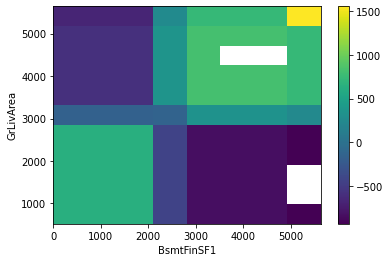

In [26]:
# Plot

X, Y = np.meshgrid(eff_grid.columns, eff_grid.index)
fig, ax = plt.subplots()
im = ax.imshow(
    eff_grid, 
    origin="lower", 
    extent=[X.min(), X.max(), Y.min(), Y.max()],
    aspect='auto',
)
cbar = fig.colorbar(im, ax=ax)
ax.set_xlabel(eff_grid.columns.name)
ax.set_ylabel(eff_grid.index.name)

In white, cells for which there were no points to obtain the ALE.